Explore the dataset
Let's first look into how the dataset looks like.

# 1 Import packages
1 import common packages
2 load train csv file and sample submission file

In [1]:
import os
import re
import json
import pickle
from collections import defaultdict, Counter
import gc
#data science imports
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
## This is to load sample files
""" Loading data"""

data_path = '/kaggle/input/coleridgeinitiative-show-us-the-data/'
def read_json_from_folder(folder_name):
    json_dict = {}
    for filename in os.listdir(folder_name):
        with open(os.path.join(folder_name, filename)) as f:
            json_dict[filename[:-5]] = json.load(f)
    return json_dict

# train_dict = read_json_from_folder(os.path.join(data_path, 'train'))
# test_dict = read_json_from_folder(os.path.join(data_path, 'test'))
#load csv filess
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
sample_sub = pd.read_csv(os.path.join(data_path,'sample_submission.csv'))
    
# len(train_dict), len(test_dict), 
train_df.shape, sample_sub.shape

((19661, 5), (4, 2))

# 2 Let's take a peak of what train data looks like

**2.1 First glimps**

In [3]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study


In [4]:
print("Distinct value in different columns:")
[print(f"{column}:{len(train_df[column].unique())}") for column in train_df.columns]

Distinct value in different columns:
Id:14316
pub_title:14271
dataset_title:45
dataset_label:130
cleaned_label:130


[None, None, None, None, None]

**Hey! It seems that dataset is labelled in batch!**
1. items are extracted from 45 datasets with 130 different label, 
2. among them, some papers are labelled with multiple labels.
3. there are 130 labels in total

In [5]:
s = set(train_df.cleaned_label)
print("Total number of distinct dataset label is ",len(s))

Total number of distinct dataset label is  130


Hey! Let's see the distribution of different topic

In [6]:
labels_info = train_df.cleaned_label.value_counts()
print(labels_info.head())

adni                                                     3673
alzheimer s disease neuroimaging initiative adni         2400
trends in international mathematics and science study    1163
baltimore longitudinal study of aging                    1156
early childhood longitudinal study                       1011
Name: cleaned_label, dtype: int64


In [7]:
labelscount = labels_info.values.sum()
print(labelscount)
labels_percentage = pd.Series({label:val/labelscount for label,val in labels_info.items()})

19661


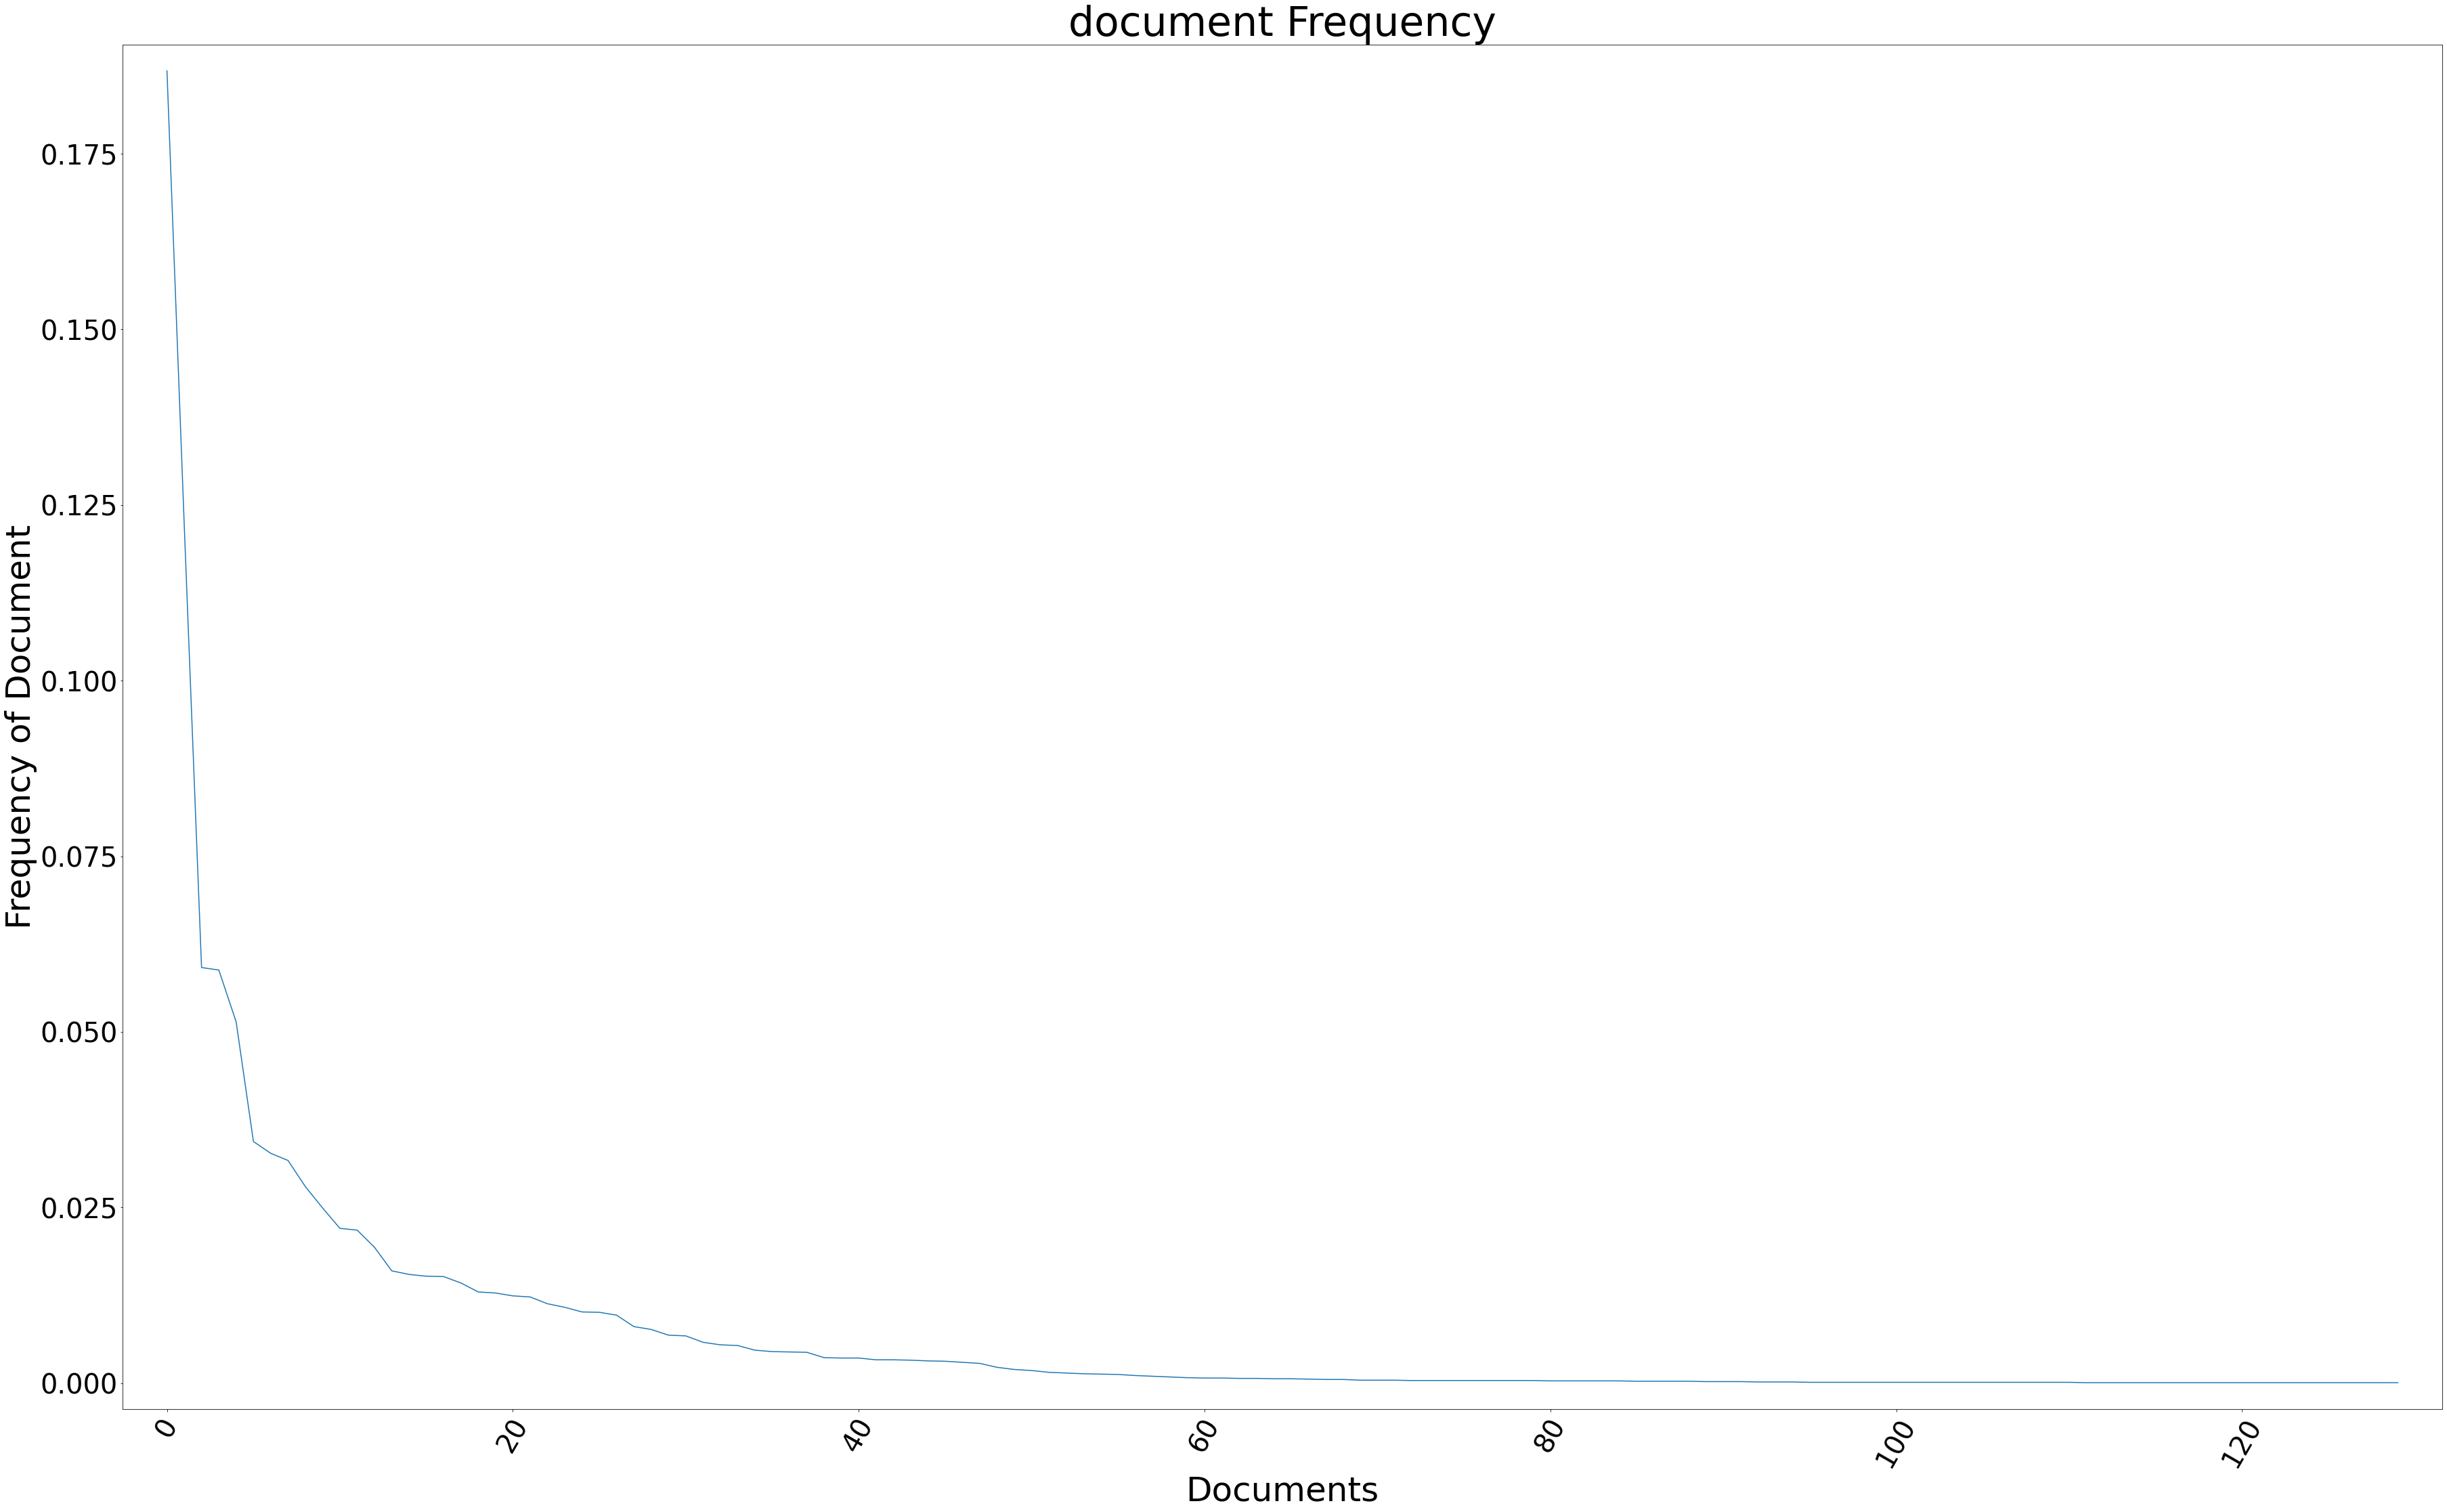

In [8]:
labels_percentage.head()
#x,y = zip(labels_percentage)
counts = labels_percentage.values
index = labels_percentage.index
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.plot(counts)
plt.xlabel('Documents', fontsize=50)
plt.ylabel('Frequency of Document', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('document Frequency', fontsize=60)
plt.show()

**2.2Read Data From json Files**

I think Abstract is more than enough to deduce the topic of a document🤣

In [9]:
#input
# doc(list)
#    chapter(list)
#        section_title(dict):Abstract
#        text(text)
def getAbstract(doc):
    res = ""
    for chapter in doc:
        if 'Abstract' in chapter.values():
            res +=  chapter['text']
        if 'Introduction' in chapter.values():
            res +=  chapter['text']
        if 'Conclusion' in chapter.values():
            res +=  chapter['text']
    if res == "":
        res += doc[0]['text']
    return res

This is to Read Files with train.csv as a 

In [10]:
# This is to read all datas from file
""" build PUB_DF by repacking data from train_df """
df = train_df.groupby('Id').agg({'pub_title':'first', 'dataset_label':'nunique',
                                    'cleaned_label':lambda x: sorted(x)})
# 以CSV为目录读取其他的文件
df['raw_text'] = pd.Series(read_json_from_folder(os.path.join(data_path, 'train')))
df['n_sections'] = df['raw_text'].apply(lambda x: len(x)).astype(int)
""" Get Abstract """
df['abstract'] = df['raw_text'].apply(lambda x: getAbstract(x))
print (df.shape)

(14316, 6)


Let's see what df looks like~😋

In [11]:
df.head()

,pub_title,dataset_label,cleaned_label,raw_text,n_sections,abstract
Id,,,,,,
0007f880-0a9b-492d-9a58-76eb0b0e0bd7,The Impact of ICT Training on Income Generatio...,1,[program for the international assessment of a...,"[{'section_title': 'Abstract', 'text': 'The ai...",20,The aim of this study was to identify if acqui...
0008656f-0ba2-4632-8602-3017b44c2e90,Finnish Ninth Graders’ Gender Appropriateness ...,1,[trends in international mathematics and scien...,"[{'section_title': 'Abstract', 'text': 'In thi...",16,"In this study, Finnish ninth graders' and thei..."
000e04d6-d6ef-442f-b070-4309493221ba,Economic Research Service: Specialized Agency...,1,[agricultural resources management survey],"[{'section_title': 'Highlights', 'text': 'Thro...",29,Through the U.S. Department of Agriculture's E...
000efc17-13d8-433d-8f62-a3932fe4f3b8,Risk factors and global cognitive status relat...,2,"[adni, alzheimer s disease neuroimaging initia...","[{'section_title': 'Abstract', 'text': 'Risk f...",11,Risk factors and cognitive sequelae of brain a...
0010357a-6365-4e5f-b982-582e6d32c3ee,Timelines of COVID-19 Vaccines,1,[genome sequence of covid 19],"[{'section_title': '', 'text': 'Potential Conf...",5,Potential Conflicts of Interest: The author ha...


## 3 Let's clean up df.abstract😏**

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation
from nltk.stem.snowball import EnglishStemmer
import re

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


We nned to make sure word are lower-case, 3 cleaning approach:
1. word are transformed into lower case
2. punctuation checked
3. word normalized
4. remove numbers

In [13]:
stop = set(stopwords.words('english'))
exclude = set(punctuation)
lemma = WordNetLemmatizer()

def removeSymbols(text):
    return re.sub(r'[\n\.\!\/_\-$%^*(+\"\')]+|[+—()?【】“”！:,;.？、~@#￥%…&*（）0123456789]+', ' ',
                                        text)
def cleanDoc(doc):
    # 
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = " ".join(ch for ch in stop_free.split() if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    cleaned = " ".join(removeSymbols(word) for word in normalized.split())
    return cleaned

def cleanDocs(docs):
    for doc in tqdm(docs.itertuples(), total = len(docs)):
        symbols_clear = removeSymbols(doc.abstract)
        cleaned = cleanDoc(symbols_clear)
        docs.loc[doc.Index,'cleaned_abstract'] = cleaned
    #return docs

Clean up text in abstrat

In [14]:
%time cleanDocs(df)

100%|██████████| 14316/14316 [01:45<00:00, 135.19it/s]

CPU times: user 1min 45s, sys: 1.71 s, total: 1min 46s
Wall time: 1min 45s


In [15]:
demo = "In this study, Finnish ninth graders' and their school guidance counselors' views concerning ninth graders' perceptions of gender-appropriateness of occupations were examined. Special interest was placed on evaluating if ninth graders bring out any gender stereotypical perceptions regarding science, technology, engineering or mathematics (STEM) occupations. The data were gathered with the aid of an online survey (246 pupils) and semi-structured interviews (7 school guidance counselors). Ninth graders referred mostly to masculine physical dimension when justifying certain occupations being more suitable for men than for women. Respectively, they referred mostly to gender-typical interest when justifying certain occupations to be more suitable for women than for men. Boys presented more gender stereotypical perceptions of occupations than girls did. Boys also considered their own gender affecting their occupational preferences stronger than girls did. Guidance counselors reported ninth graders' perceptions of occupations being still very gender-stereotypic and influencing on academic and occupational choices. To address occupational gender segregation, it is necessary to develop novel methods and materials recognizing gender stereotypes and demonstrating up-to-date STEM career knowledge."
cleanDoc(demo)
print("#1 This is cleaned abstract:\n",df.cleaned_abstract[1])
print("#2 This is original abstract:\n",df.abstract[1])

#1 This is cleaned abstract:
 study finnish ninth grader school guidance counselor view concerning ninth grader perception gender appropriateness occupation examined special interest placed evaluating ninth grader bring gender stereotypical perception regarding science technology engineering mathematics stem occupation data gathered aid online survey pupil semi structured interview school guidance counselor ninth grader referred mostly masculine physical dimension justifying certain occupation suitable men woman respectively referred mostly gender typical interest justifying certain occupation suitable woman men boy presented gender stereotypical perception occupation girl boy also considered gender affecting occupational preference stronger girl guidance counselor reported ninth grader perception occupation still gender stereotypic influencing academic occupational choice address occupational gender segregation necessary develop novel method material recognizing gender stereotype demo

Well, this takes a while~

**2.2.2 And then we need to look into cleaned label**☺️

In [16]:
# Actually, label is not always clean, it contains many punctuations
df.cleaned_label.head()

Id
0007f880-0a9b-492d-9a58-76eb0b0e0bd7    [program for the international assessment of a...
0008656f-0ba2-4632-8602-3017b44c2e90    [trends in international mathematics and scien...
000e04d6-d6ef-442f-b070-4309493221ba           [agricultural resources management survey]
000efc17-13d8-433d-8f62-a3932fe4f3b8    [adni, alzheimer s disease neuroimaging initia...
0010357a-6365-4e5f-b982-582e6d32c3ee                        [genome sequence of covid 19]
Name: cleaned_label, dtype: object

In [17]:
def remove_stop(doc):
    labels = []
    for label in doc:
        new_seq = " ".join(word for word in label.split() if word not in stop)
        labels.append(new_seq)
    return labels
%time df['cleaned_nostop_label'] = df['cleaned_label'].apply(lambda x: remove_stop(x))

CPU times: user 38.2 ms, sys: 2.01 ms, total: 40.2 ms
Wall time: 39.7 ms


In [18]:
print(df.cleaned_label.head())
print(df.cleaned_nostop_label.head())

Id
0007f880-0a9b-492d-9a58-76eb0b0e0bd7    [program for the international assessment of a...
0008656f-0ba2-4632-8602-3017b44c2e90    [trends in international mathematics and scien...
000e04d6-d6ef-442f-b070-4309493221ba           [agricultural resources management survey]
000efc17-13d8-433d-8f62-a3932fe4f3b8    [adni, alzheimer s disease neuroimaging initia...
0010357a-6365-4e5f-b982-582e6d32c3ee                        [genome sequence of covid 19]
Name: cleaned_label, dtype: object
Id
0007f880-0a9b-492d-9a58-76eb0b0e0bd7    [program international assessment adult compet...
0008656f-0ba2-4632-8602-3017b44c2e90     [trends international mathematics science study]
000e04d6-d6ef-442f-b070-4309493221ba           [agricultural resources management survey]
000efc17-13d8-433d-8f62-a3932fe4f3b8    [adni, alzheimer disease neuroimaging initiati...
0010357a-6365-4e5f-b982-582e6d32c3ee                           [genome sequence covid 19]
Name: cleaned_nostop_label, dtype: object


# 4Vectorize abstract and labels
1. text is vectorized with TF-IDF 
2. labels are vectorized with BOW model
3. TODO: text representation with doc2vec

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Format input data

In [20]:
df.cleaned_abstract.head()
df.cleaned_label.head()

Id
0007f880-0a9b-492d-9a58-76eb0b0e0bd7    [program for the international assessment of a...
0008656f-0ba2-4632-8602-3017b44c2e90    [trends in international mathematics and scien...
000e04d6-d6ef-442f-b070-4309493221ba           [agricultural resources management survey]
000efc17-13d8-433d-8f62-a3932fe4f3b8    [adni, alzheimer s disease neuroimaging initia...
0010357a-6365-4e5f-b982-582e6d32c3ee                        [genome sequence of covid 19]
Name: cleaned_label, dtype: object

In [21]:
def textToList(docs):
    abs_list = []
    for doc in tqdm(docs.itertuples(), total = len(docs)):
        abs_list.append(doc.cleaned_abstract)
    return abs_list
train_data = textToList(df)
def labelToList(docs):
    abs_list = []
    for doc in tqdm(docs.itertuples(), total = len(docs)):
        labels = []
        for label in doc.cleaned_label:
            labels.append(label)
        abs_list.append(' '.join(labels))
    return abs_list
train_label_ = labelToList(df)

100%|██████████| 14316/14316 [00:00<00:00, 277748.69it/s]


In [22]:
data_vectorizer = TfidfVectorizer(max_features=1000, input='content',# analyzer=stemmed_words,
                             stop_words='english'
                             , encoding='utf-8', decode_error='ignore',
                            lowercase=True, ngram_range=(1, 3))

In [23]:
data_vectorizer.fit(train_label_)

TfidfVectorizer(decode_error='ignore', max_features=1000, ngram_range=(1, 3),
                stop_words='english')

In [24]:
# vocabulary is word:index
vocabulary = data_vectorizer.vocabulary_
#dictionary is index:word
dictionary = dict(zip(vocabulary.values(), vocabulary.keys()))

In [25]:
train_data_matrix = data_vectorizer.transform(train_data)

In [26]:
train_data_matrix.shape

(14316, 1000)

# Onehot encode

In [27]:
def labelToLabelList(docs):
    abs_list = []
    for doc in tqdm(docs.itertuples(), total = len(docs)):
        labels = []
        for label in doc.cleaned_label:
            labels.append(label)
        abs_list.append(labels)
    return abs_list
train_label = labelToLabelList(df)

100%|██████████| 14316/14316 [00:00<00:00, 293363.57it/s]


In [28]:
label_set = set(train_df.cleaned_label.unique())
# 0-129
# label: index
label_vocabulary = dict([(label,index)for index,label in enumerate(label_set)])
# index:label
label_dictionary= dict(zip(label_vocabulary.values(), label_vocabulary.keys()))

In [29]:
def dense_to_one_hot():
    """Convert class labels from scalars to one-hot vectors."""
    labels_one_hot = np.zeros((len(train_label), len(label_set)))
    for i, labels in enumerate(train_label):
        for label in labels:
            labels_one_hot[i][label_vocabulary[label]] = 1
    return labels_one_hot
train_label1 = dense_to_one_hot()

In [30]:
label_array = train_label1
data_array = train_data_matrix.toarray()

不用这个了！！

# 5 XGB model training

In [31]:
print(label_array.shape)
print(data_array.shape)

(14316, 130)
(14316, 1000)


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, explained_variance_score, hamming_loss

In [33]:

X_train, X_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.1, random_state=0)

In [34]:
# create XGBoost instance with default hyper-parameters
xgb_estimator = XGBClassifier(tree_method='gpu_hist',objective='binary:logistic', eval_metric = 'logloss')

# create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# fit the model
%time multilabel_model.fit(X_train, y_train)

# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, multilabel_model.predict(X_test))*100))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 1min 40s, sys: 9.36 s, total: 1min 49s
Wall time: 1min 37s
Accuracy on test data: 42.7%


In [35]:
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, multilabel_model.predict(X_test))*100))

Accuracy on test data: 42.7%


## Addition Literal matching

In [36]:
sample_sub = pd.read_csv(os.path.join(data_path,'sample_submission.csv'))


In [37]:
all_labels = set()

for label_1, label_2, label_3 in train_df[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    all_labels.add(str(label_1).lower())
    all_labels.add(str(label_2).lower())
    all_labels.add(str(label_3).lower())
    
print(f'No. different labels: {len(all_labels)}')

No. different labels: 180


In [38]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt

In [39]:
paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
papers = {}
for paper_id in sample_sub['Id']:
    with open(f'{paper_test_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

literal_preds = dict()

for paper_id in sample_sub['Id']:
    paper = papers[paper_id]
    text_1 = '. '.join(section['text'] for section in paper).lower()
    text_2 = totally_clean_text(text_1)
    
    labels = []
    for label in all_labels:
        if label in text_1 or label in text_2:
            labels.append(clean_text(label))
    
    literal_preds[paper_id] = labels


In [40]:
literal_preds

{'2100032a-7c33-4bff-97ef-690822c43466': ['adni',
  'alzheimer s disease neuroimaging initiative adni',
  'alzheimer s disease neuroimaging initiative adni'],
 '2f392438-e215-4169-bebf-21ac4ff253e1': ['nces common core of data',
  'trends in international mathematics and science study',
  'common core of data'],
 '3f316b38-1a24-45a9-8d8c-4e05a42257c6': ['slosh model',
  'noaa storm surge inundation',
  'sea lake and overland surges from hurricanes'],
 '8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60': ['rural urban continuum codes',
  'rural urban continuum codes']}

# 6 This is to load test data and generate result

In [41]:
test_data_path = '../input/coleridgeinitiative-show-us-the-data/test'
def read_json_pub(Id):
    filename = os.path.join(test_data_path, Id+'.json')
    with open(filename) as f:
        json_pub = json.load(f)
    return json_pub

In [42]:
def clean_doc(text):    
    symbols_clear = removeSymbols(text)
    cleaned = cleanDoc(symbols_clear)
    return cleaned

In [43]:
def prepare_data(text):
    abstract = getAbstract(text)
    cleaned_abstract = clean_doc(abstract)
    return abstract

In [44]:
# use literal_preds
def get_result(result, literal_labels):
    prob = dict()
    for i, r in enumerate(result):
        prob[i] = r[0][1]
    prob=sorted(prob.items(),key=lambda x:x[1],reverse=True)
    res = []
    highest_score = prob[0][1]
    for topic_info in prob:
        if topic_info[1]/highest_score>0.9 or topic_info[1]>0.5:
            res.append(label_dictionary[topic_info[0]])
    for label in literal_labels:
        if label not in res:
            res.append(label)
    return ' | '.join(res)        

In [45]:
sample_sub = pd.read_csv(os.path.join(data_path,'sample_submission.csv'))
sub = sample_sub.copy()
for index, row in tqdm(sub.iterrows()):
    row_id = row['Id']
    text = read_json_pub(row_id)
    text = prepare_data(text)
    textVec = data_vectorizer.transform([text])
    #print(textVec)
    result = multilabel_model.predict_proba(textVec)
    sub.PredictionString[sub.Id == row_id] = get_result(result, literal_preds[row_id])
    #Id_list.append(row_id)
    #sub.PredictionString[sub.Id == row_id] = get_result(text)

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
4it [00:00, 26.34it/s]


In [46]:
sub

,Id,PredictionString
0,2100032a-7c33-4bff-97ef-690822c43466,our world in data | adni | alzheimer s disease...
1,2f392438-e215-4169-bebf-21ac4ff253e1,survey of graduate students and postdoctorates...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model | noaa storm surge inundation | se...
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [47]:
sub.to_csv('submission.csv', index=False)